# phidl.waveguides tutorial
Waveguides are like wires for light. From a layout standpoint, that means they share concepts of routing and ports. Unlike in wires, the device geometry is often three-dimensional, and all transitions must be smooth.

`phidl` treats waveguides as extrusions of waveguige _cross-sections_. These cross sections can have multiple components in different layers. When combined with your process information (e.g. different etch depths), the cross section defines the geometry of your waveguide as viewed along the axis of light propagation.

XSections are turned into to waveguide Devices as defined by extrusion curves in the plane of the chip. They can be straight or arcs or sequences of arcs of smoothly changing radii (a.k.a. an Euler bend). Extrusions along Bezier or parametric curves are not implemented or needed in typical waveguide circuits. Each XSection has a minimium radius defined so that light does not escape around bent regions.

Let's make some waveguides

In [1]:
# Boilerplate stuff 
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings("ignore")

import sys, os
sys.path.insert(0, '..')

from phidl import Device, Layer, LayerSet
from phidl import quickplot as qp
import matplotlib.pyplot as plt

# import phidl.geometry as pg
from phidl.waveguides import WG_XS, WG_XS_Component, concatenate_waveguides

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# Get some meaningful layers ready
lys = LayerSet()
lys.add_layer('si_thick', gds_layer=5)
lys.add_layer('si_thin', gds_layer=1)
lys.add_layer('dope_n', gds_layer=2)
lys.add_layer('dope_p', gds_layer=3)

## Basics
[__Version note__: this tutorial was made with method-style waveguide generation, although with an awareness that it might change to function-style]

__`WG_XS` is the workhorse of `phidl.waveguides`.__ It has an attribute "components" that contains `WG_XS_Components`. Both of these hold attributes and give useful manipulations such as filtering, copying, and sanity checking. 

__A "Waveguide" is a `phidl.Device` instance.__ They are created by different generation functions applied to a `WG_XS` object. Currently, these generation functions are methods of `WG_XS`. All Waveguides have ports 'wg_in_1' and 'wg_out_1' and info 'wg_length'. This is convention, not subclassing.

#### The generation functions, covered below
- cell_straight
- cell_bend
- cell_euler_bend [author note: consider making this private and relying on euler kwarg in cell_bend]
- cell_s_bend
- cell_s_bend_by_offset [author note: this is commonly used but maybe not core functionality]
- cell_taper
- route_points
- route_ports_manhattan

### A minimal example

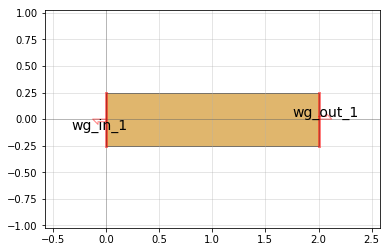

In [67]:
xs_strip = WG_XS()
strip_comp = WG_XS_Component(layer=lys['si_thick'], width=.5, offset=0)
xs_strip.components.append(strip_comp)

wg = xs_strip.cell_straight(2)  # wg is a Device

qp(wg)

### Compound XSections

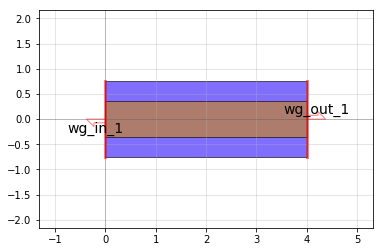

In [68]:
xs_rib = WG_XS()
thin_comp = WG_XS_Component(layer=lys['si_thin'], width=1.5, offset=0)
thick_comp = WG_XS_Component(layer=lys['si_thick'], width=.8, offset=0)
xs_rib.components.extend([thick_comp, thin_comp])

qp(xs_rib.cell_straight(4))

## Component offsets, mutability, access, and manipulation
### Illustrated with a PN junction
Let's make a XSection that has an embedded PN junction. It has the same silicon composition as `xs_rib`. This will show how to copy a `WG_XS`.

To ease visualization, we will make a preview `compound_preview` that puts just the dopants, just the silicon, and the full thing next to one another.

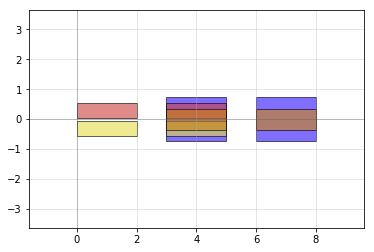

In [169]:
xs_dopants = WG_XS()
xs_dopants.components.append(WG_XS_Component(layer=lys['dope_n'], width=.5, offset=.3))
xs_dopants.components.append(WG_XS_Component(layer=lys['dope_p'], width=.5, offset=-.3))

xs_junction = xs_rib.copy()
xs_junction.components.extend(xs_dopants.components)

def compound_preview():
    D = Device('PN junction demo')
    preview1 = D << xs_dopants.cell_straight(2)
    preview2 = D << xs_rib.cell_straight(2)
    pn_wg = D << xs_junction.cell_straight(2)
    preview2.movex(6)
    pn_wg.movex(3)
    qp(D)
    
compound_preview()

### Optional: visualization
You can visualize cross-sections in KLayout with the [xsection](https://klayoutmatthias.github.io/xsection/) package. It can be very useful, but it takes a little setup that won't be covered here. Here is a visualization of the PN junction we just made.

<img src="pn_junction_xs.png" alt="Drawing" style="width: 600px;"/>

### Mutability
Take note of an important difference above. The `xs_junction` was _copied_ from `xs_rib`, and its components were _extended_ by the components in `xs_dopants`. That means the dopant components reference the same objects. Let's change them and see what happens to the same plot.

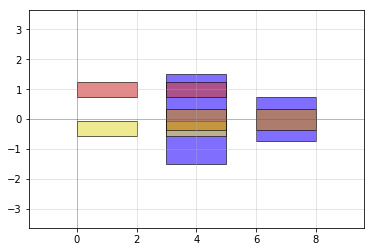

In [170]:
xs_junction.components[1].width = 3  # The si_thin component
xs_junction.components[2].offset = 1  # The dope_n component

compound_preview()

The left section changed, and the one on the right did not. Basically, `WG_XS.copy` makes new property holder instances, whereas list assignment just copies references to the same instances. Be warned.

### Component access and property helpers
The component order does not matter, so it is futile to keep track of their index in the list. Instead, we would like to pick out components based on their layer using `get_by_layer`.

Components positions are fully defined by width and offset, but it is usually more convenient to address their `min`/`max` or `inner`/`outer`. Inner and outer behavior changes side depending on the sign of the offset, making it very useful for dopants.

In this cell, we'll 
- make the thick Si wider, 
- remove the thin Si, and
- make the dopants symmetric.

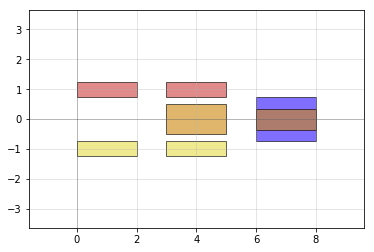

In [171]:
thick_comp = xs_junction.get_by_layer(lys['si_thick'])[0]
thick_comp.min = -.5
thick_comp.max = .5

thin_comp = xs_junction.get_by_layer(lys['si_thin'])[0]
xs_junction.components.remove(thin_comp)

n_comp = xs_junction.get_by_layer(lys['dope_n'])[0]
p_comp = xs_junction.get_by_layer(lys['dope_p'])[0]
p_comp.outer = n_comp.outer
p_comp.inner = n_comp.inner

compound_preview()

## Euler bends
### Illustrated with loop resonators
A straight section connected to an arc results in a discontinuous radius of curvature. Since the mode in a waveguide depends slightly on this radius or curvature, there is a modal mismatch and then loss incurred at these transitions.

The solution is to create shapes where the radius of curvature gradually transitions from straight to curved. These are called Euler curves or "track transition curves" when used in railroad and highway planning. In waveguide cases, we will always want to return back to straight.

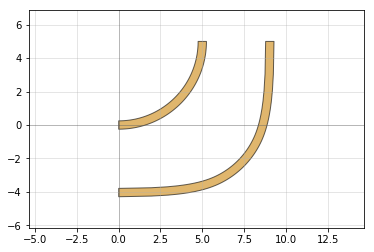

In [172]:
D = Device('Euler demo')
arc = D << xs_strip.cell_bend(90, euler=False)
eul = D << xs_strip.cell_bend(90, euler=True)
eul.ymax = arc.ymax
qp(D)

Notice that the radius for the Euler curve refers to its minimum radius (defaulting here to 5 $\mu$m). It ends up being larger than the corresponding arc because it needs more room for the transition. 

Sometimes you need to know where the ports fall for the purposes of routing or other calculations. Every Euler bend has a corresponding arc with identical ports. It's radius depends nontrivially on the minimum radius _and also angle of the turn_. Euler waveguides have an `info['Reff']` calculated on the fly, where this radius is that of the equivalent arc. We can use that information to, for example, close a "circle."

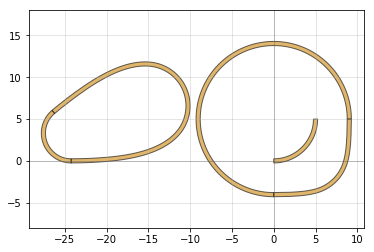

In [173]:
closer = D << xs_strip.cell_bend(270, radius=eul.info['Reff'], euler=False)
closer.connect('wg_in_1', eul.ports['wg_out_1'])

# A more difficult case
eul2 = D << xs_strip.cell_bend(220, euler=True)
eul2.xmax = eul.xmin - 10
closer2 = D << xs_strip.cell_bend(140, radius=eul2.info['Reff'], euler=False)
closer2.connect('wg_in_1', eul2.ports['wg_out_1'])

qp(D)

## Tapers and concatenations
### Illustrated with waveguide LEDs
Many devices contain multiple types of XSections. These need to transition smoothly between on another. What could be a large number of sections are then connected in series. Here we will make a fairly complicated device with a PN junction gain region tapering out to a regular waveguide for routing.

In this section, a persistent device is built incrementally. If something goes wrong, you must come back to this cell and run through them again

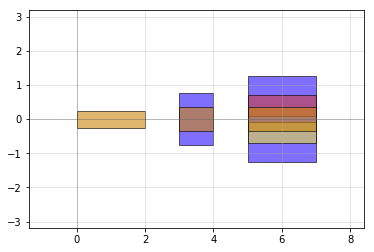

In [174]:
xs_gain = WG_XS()
xs_gain.components.append(WG_XS_Component(layer=lys['si_thin'], width=2.5, offset=0))
xs_gain.components.append(WG_XS_Component(layer=lys['si_thick'], width=.7, offset=0))
xs_gain.components.append(WG_XS_Component(layer=lys['dope_n'], width=.6, offset=.4))
xs_gain.components.append(WG_XS_Component(layer=lys['dope_p'], width=.6, offset=-.4))

D = Device('LED demo')
wg_gain = D << xs_gain.cell_straight(2)
wg_gain.movex(5)
wg_midtaper = D << xs_rib.cell_straight(1)
wg_midtaper.movex(3)
wg_routing = D << xs_strip.cell_straight(2)

qp(D)

Tapers are characterized by two XSections.

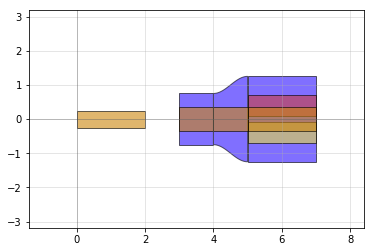

In [175]:
taper1 = D << xs_rib.cell_taper(xs_gain, 1)
taper1.movex(4)
qp(D)

### Keeping layers
See above how the dopants were not included in the taper. They do not exist in `xs_rib`. For the transition to the strip waveguide, we don't want the thin Si to simply vanish. Instead we want it to taper to a tip. Tips cannot be zero width, so you can control it's width based on your fabrication requirements.

[Author note: keep_layernames should be changed to keep_layers]

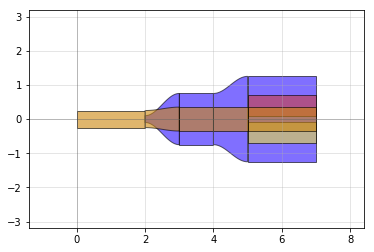

In [176]:
taper2 = D << xs_strip.cell_taper(xs_rib, 1, keep_layernames=['si_thin'], min_tip_width=.2)
taper2.movex(2)
qp(D)

### Terminators
Abruptly ending a waveguide leads to reflections. Terminators are tapers into nothing. They force the optical mode out of the waveguide before it ends. This cell also illustrates connecting usign the 'wg_in_1' ports.

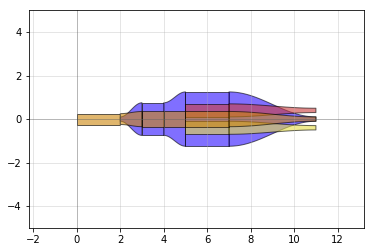

In [177]:
terminator1 = D << xs_gain.cell_taper(None, 4, min_tip_width=.2)
terminator1.connect('wg_in_1', wg_gain.ports['wg_out_1'])
qp(D)

__Oh crap!__ The dopants are still there. We usually don't want that. The problem is that the `None` argument doesn't have any components, so `cell_taper` does not know which layers are desired. By default, it keeps them all. To fix this, we will take dopants away from a copy of the gain XSection.

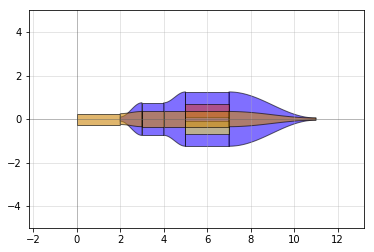

In [178]:
try:
    D.remove(terminator1)  # get rid of that one
except ValueError:
    pass

bare_gain = xs_gain.copy()
_ = [bare_gain.components.remove(bare_gain.get_by_layer(lay)[0]) for lay in [lys['dope_n'], lys['dope_p']]]
terminator2 = D << bare_gain.cell_taper(None, 4)
terminator2.connect('wg_in_1', wg_gain.ports['wg_out_1'])
qp(D)

### The easy way: waveguide concatenation
Notice all the `movex`'s above? That would become very difficult to keep track of when orientations or lengths are changing. It would be better to use phidl's `DeviceReference.connect` capabilities. However, this would lead to a lot of variables, lots of `add_ref`'s, and a lot of `connect` commands. 

The easier way is to put the waveguide sections in a list and connect them all together using `concatenate_waveguides`. Remember a waveguide is a `Device` that must follow the convention of ports 'wg_in_1' and 'wg_out_1' (and possibly other ports).

Let's recreate the LED except without a termination.

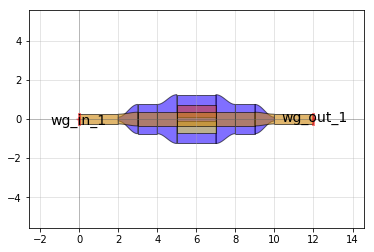

In [179]:
def LED():
    secs = []
    secs.append(xs_strip.cell_straight(2))
    secs.append(xs_strip.cell_taper(xs_rib, 1, keep_layernames=['si_thin'], min_tip_width=0.2))
    secs.append(xs_rib.cell_straight(1))
    secs.append(xs_rib.cell_taper(xs_gain, 1))
    secs.append(xs_gain.cell_straight(2))  # this is the center, and the rest will roughly mirror the above
    secs.append(xs_gain.cell_taper(xs_rib, 1))
    secs.append(xs_rib.cell_straight(1))
    secs.append(xs_rib.cell_taper(xs_strip, 1, keep_layernames=['si_thin'], min_tip_width=0.2))
    secs.append(xs_strip.cell_straight(2))
    
    return concatenate_waveguides(secs)
    
qp(LED())

## Routing
Let's do some Manhattan routing. Manhattan routing between ports can only happen on a rectilinear grid. The function `route_ports_manhattan` makes a waveguide with the appropriate bends.

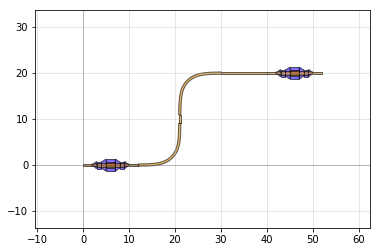

In [180]:
D = Device('Manhattan demo')
led1 = D << LED()
led2 = D << LED()
led2.move((40, 20))

D << xs_strip.route_ports_manhattan(led1.ports['wg_out_1'], led2.ports['wg_in_1'], euler=True)

qp(D)

Manhattan routing automatically works with ports of varying orientations. In this case orientation is zero.

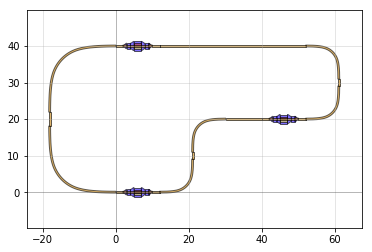

In [181]:
led3 = D << LED()
led3.move((0, 40))

D << xs_strip.route_ports_manhattan(led1.ports['wg_in_1'], led3.ports['wg_in_1'], radius=10, euler=True)
D << xs_strip.route_ports_manhattan(led2.ports['wg_out_1'], led3.ports['wg_out_1'], euler=True)

qp(D)

In [182]:
from lyipc.client import kqp
kqp(D, fresh=True)